* Author: HZQ
* Last modified: 2019/2/14

# Main Parts

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools 
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null 
!apt-get update -qq 2>&1 > /dev/null 
!apt-get -y install -qq google-drive-ocamlfuse fuse 
from google.colab import auth 
auth.authenticate_user() 
from oauth2client.client import GoogleCredentials 
creds = GoogleCredentials.get_application_default() 
import getpass 
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL 
vcode = getpass.getpass() 
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p driver
!google-drive-ocamlfuse driver
import os
os.chdir("driver/Colab Notebooks/CategoryRecom_kaggle/")
!ls

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
data	  driver   model      requirements.txt	timeline
download  LICENSE  ReadMe.md  submit		utils


In [0]:
!ls

data	  driver		LICENSE  ReadMe.md	   submit    utils
download  lgbm_importances.png	model	 requirements.txt  timeline


## Import required packages

In [0]:
!pip install --upgrade pandas

In [0]:
import gc, sys, time

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

%matplotlib inline

## prepared process


### read data offline

In [0]:
DATA_ROOT_PATH = "./data/"

In [0]:
data_train_path = DATA_ROOT_PATH + "data_raw/train/train.csv"
data_test_path = DATA_ROOT_PATH + "data_raw/test/test.csv"
data_valid_path = DATA_ROOT_PATH + "data_raw/valid/valid.csv"

data_info_path = DATA_ROOT_PATH  + "data_raw/Data_Dictionary.xlsx"

data_train_raw = pd.read_csv(data_train_path)
data_test_raw = pd.read_csv(data_test_path)

In [0]:
data_train = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_train_all_IC_20190214.csv")
data_test = pd.read_csv(DATA_ROOT_PATH+"data_processed/test/data_test_all_IC_20190214.csv")

# data_train = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/train_full_scaled_20190203.csv")
# data_test = pd.read_csv(DATA_ROOT_PATH+"data_processed/test/test_full_scaled_20190203.csv")

# data_train = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_train_full_scaled_selected.csv")
# data_test = pd.read_csv(DATA_ROOT_PATH+"data_processed/test/data_test_full_scaled_selected.csv")

In [0]:
print(data_train.shape, data_train_raw.shape)
print(data_test.shape, data_test_raw.shape)

(201917, 391) (201917, 6)
(123623, 391) (123623, 5)


In [0]:
data_train.info(verbose=True, memory_usage="deep")

In [0]:
data_test.info(verbose=True, memory_usage="deep")

In [0]:
labels = data_train_raw["target"]
data_train.drop(["target", "card_id"], axis=1, inplace=True)
data_test.drop(["card_id"], axis=1, inplace=True)

### read data online

## model training

### baseline model: (e.g Linear regression)

#### LGBM, copied from [Elo world](https://www.kaggle.com/fabiendaniel/elo-world)

In [0]:
train =  pd.read_csv("./download/elo_world/train.csv")
test = pd.read_csv("./download/elo_world/test.csv")

In [0]:
target = train["target"]
del train["target"]

In [0]:
# unimportant_features = [
#     'auth_category_2_1.0_mean',
#     'auth_category_2_2.0_mean',
#     'auth_category_2_3.0_mean',
#     'auth_category_2_5.0_mean',
#     'hist_category_2_3.0_mean',
#     'hist_category_2_4.0_mean',
#     'hist_category_2_5.0_mean',
#     'hist_category_3_A_mean',
#     'hist_installments_min',
#     'hist_installments_std',
#     'hist_month_lag_std',
#     'hist_purchase_amount_max',
#     'hist_purchase_month_max',
#     'hist_purchase_month_min',
#     'hist_purchase_month_std',
#     'installments_min_mean',
#     'new_category_2_1.0_mean',
#     'new_category_2_2.0_mean',
#     'new_category_2_3.0_mean',
#     'new_category_2_5.0_mean',
#     'new_city_id_nunique',
#     'new_installments_std',
#     'new_state_id_nunique',
#     'purchase_amount_mean_mean'
# ]
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
#features = [f for f in features if f not in unimportant_features]
categorical_feats = ['feature_2', 'feature_3']

We then set the hyperparameters of the LGBM model, these parameters are obtained by an [bayesian optimization done in another kernel](https://www.kaggle.com/fabiendaniel/hyperparameter-tuning/edit):

In [0]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

We now train the model. Here, we use a standard KFold split of the dataset in order to validate the results and to stop the training. Interstingly, during the writing of this kernel, the model was enriched adding new features, which improved the CV score. **The variations observed on the CV were found to be quite similar to the variations on the LB**: it seems that the current competition won't give us headaches to define the correct validation scheme:

In [0]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.71468	valid_1's rmse: 3.77695
[200]	training's rmse: 3.64555	valid_1's rmse: 3.72848
[300]	training's rmse: 3.60133	valid_1's rmse: 3.70481
[400]	training's rmse: 3.57038	valid_1's rmse: 3.69243
[500]	training's rmse: 3.54651	valid_1's rmse: 3.68511
[600]	training's rmse: 3.52747	valid_1's rmse: 3.68071
[700]	training's rmse: 3.51197	valid_1's rmse: 3.67756
[800]	training's rmse: 3.49773	valid_1's rmse: 3.67571
[900]	training's rmse: 3.48503	valid_1's rmse: 3.67437
[1000]	training's rmse: 3.47259	valid_1's rmse: 3.67341
[1100]	training's rmse: 3.46002	valid_1's rmse: 3.67262
[1200]	training's rmse: 3.44899	valid_1's rmse: 3.67175
[1300]	training's rmse: 3.43792	valid_1's rmse: 3.67173
[1400]	training's rmse: 3.42687	valid_1's rmse: 3.67136
[1500]	training's rmse: 3.41689	valid_1's rmse: 3.6713
[1600]	training's rmse: 3.40623	valid_1's rmse: 3.67105
[1700]	training's rmse: 3.39648	valid_1's rmse: 3.6

In [0]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("./submit/submission_LGBM_hzq_baseline1.csv", index=False)

### used model

|SectionName|Reference|
|:--:|:--:|
|*LGBM*|[Elo world](https://www.kaggle.com/fabiendaniel/elo-world)



#### LGBM

In [0]:
import logging


def create_logger():
    '''
    This fuction will create a logger for recording training details
    '''
    
    FORMAT = '[%(levelname)s]%(asctime)s:%(name)s:%(message)s'
    logging.basicConfig(format=FORMAT)
    logger = logging.getLogger('main')
    logger.setLevel(logging.DEBUG)
    
    return logger

logger = create_logger()

In [0]:
param = {'num_leaves': 51,
         'min_data_in_leaf': 35, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.008,
         "boosting": "gbdt",
         "feature_fraction": 0.85,
         "bagging_freq": 1,
         "bagging_fraction": 0.82,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.11,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 2019}

In [0]:
# # Add outliers checking for training data if neccessary


data_train["Outlier"] = 0
data_train.loc[labels[labels < -30].index, "Outlier"] = 1
data_train.loc[labels[labels == 0].index, "Outlier"] = 1

# Drop categorical column feats if needed


data_train.drop(data_train.select_dtypes(include=['object']), axis=1, inplace=True)
data_test.drop(data_test.select_dtypes(include=['object']), axis=1, inplace=True)

In [0]:
train_columns = list(data_train.columns)
train_columns.remove("Outlier")
test_columns = train_columns

In [0]:
categorical_feats = ['feature_2', 'feature_3']

n_splits_num = 5
folds = StratifiedKFold(n_splits=n_splits_num, shuffle=True, random_state=2019)
oof = np.zeros(len(data_train))
loss_train, loss_valid = {each_fold: [] for each_fold in range(n_splits_num)}, {each_fold: [] for each_fold in range(n_splits_num)}
predictions = np.zeros(len(data_test))
feature_importance_df = pd.DataFrame()

logger.info('Start running model')
for fold_, (trn_idx, val_idx) in enumerate(folds.split(data_train, data_train["Outlier"].values)):
    strLog = "fold {}".format(fold_)
    print(strLog) 
    trn_data = lgb.Dataset(data_train.iloc[trn_idx][train_columns], 
                           label=labels.iloc[trn_idx]) #, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(data_train.iloc[val_idx][train_columns],
                           label=labels.iloc[val_idx]) #, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, 
                    trn_data, 
                    num_round, 
                    valid_sets = [trn_data, val_data],
                    verbose_eval=200, 
                    early_stopping_rounds = 150)
    oof[val_idx] = clf.predict(data_train.iloc[val_idx][train_columns], 
                               num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    gc.collect()
    sys._clear_type_cache()
    loss_train[fold_].append(np.sqrt(mean_squared_error(oof[trn_idx], labels[trn_idx])))
    loss_valid[fold_].append(np.sqrt(mean_squared_error(oof[val_idx], labels[val_idx])))
    
    predictions += clf.predict(data_test[test_columns], 
                               num_iteration=clf.best_iteration) / folds.n_splits
    logger.info(strLog)
    
strRMSE = np.sqrt(mean_squared_error(oof, labels))
print("CV score is : %8.5f" %(strRMSE))

[INFO]2019-02-14 13:03:50,578:main:Start running model


fold 0
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.5567	valid_1's rmse: 3.67998
[400]	training's rmse: 3.44196	valid_1's rmse: 3.66195
[600]	training's rmse: 3.36539	valid_1's rmse: 3.6572
[800]	training's rmse: 3.30371	valid_1's rmse: 3.65362
[1000]	training's rmse: 3.24888	valid_1's rmse: 3.65269
[1200]	training's rmse: 3.19874	valid_1's rmse: 3.65242
[1400]	training's rmse: 3.15355	valid_1's rmse: 3.65233
Early stopping, best iteration is:
[1305]	training's rmse: 3.17397	valid_1's rmse: 3.65191


[INFO]2019-02-14 13:10:52,912:main:fold 0


fold 1
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.54853	valid_1's rmse: 3.73534
[400]	training's rmse: 3.43499	valid_1's rmse: 3.71415
[600]	training's rmse: 3.3585	valid_1's rmse: 3.70689
[800]	training's rmse: 3.29737	valid_1's rmse: 3.70485
[1000]	training's rmse: 3.24307	valid_1's rmse: 3.70427
[1200]	training's rmse: 3.19219	valid_1's rmse: 3.70463
Early stopping, best iteration is:
[1063]	training's rmse: 3.22719	valid_1's rmse: 3.70387


[INFO]2019-02-14 13:16:53,490:main:fold 1


fold 2
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.56206	valid_1's rmse: 3.65807
[400]	training's rmse: 3.44529	valid_1's rmse: 3.64078
[600]	training's rmse: 3.36903	valid_1's rmse: 3.63628
[800]	training's rmse: 3.30453	valid_1's rmse: 3.63448
[1000]	training's rmse: 3.2501	valid_1's rmse: 3.63493
Early stopping, best iteration is:
[855]	training's rmse: 3.28889	valid_1's rmse: 3.63408


[INFO]2019-02-14 13:21:58,806:main:fold 2


fold 3
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.54776	valid_1's rmse: 3.72521
[400]	training's rmse: 3.43238	valid_1's rmse: 3.71041
[600]	training's rmse: 3.35567	valid_1's rmse: 3.70562
[800]	training's rmse: 3.29363	valid_1's rmse: 3.70382
[1000]	training's rmse: 3.24043	valid_1's rmse: 3.70188
[1200]	training's rmse: 3.19244	valid_1's rmse: 3.7013
Early stopping, best iteration is:
[1214]	training's rmse: 3.18944	valid_1's rmse: 3.70116


[INFO]2019-02-14 13:28:38,912:main:fold 3


fold 4
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.5588	valid_1's rmse: 3.69444
[400]	training's rmse: 3.44522	valid_1's rmse: 3.67325
[600]	training's rmse: 3.36825	valid_1's rmse: 3.66728
[800]	training's rmse: 3.30606	valid_1's rmse: 3.66457
[1000]	training's rmse: 3.25176	valid_1's rmse: 3.66416
[1200]	training's rmse: 3.20196	valid_1's rmse: 3.66348
Early stopping, best iteration is:
[1187]	training's rmse: 3.20517	valid_1's rmse: 3.6633


[INFO]2019-02-14 13:35:12,382:main:fold 4


CV score is :  3.67097


[INFO]2019-02-14 11:17:02,330:main:Feature importance plot
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


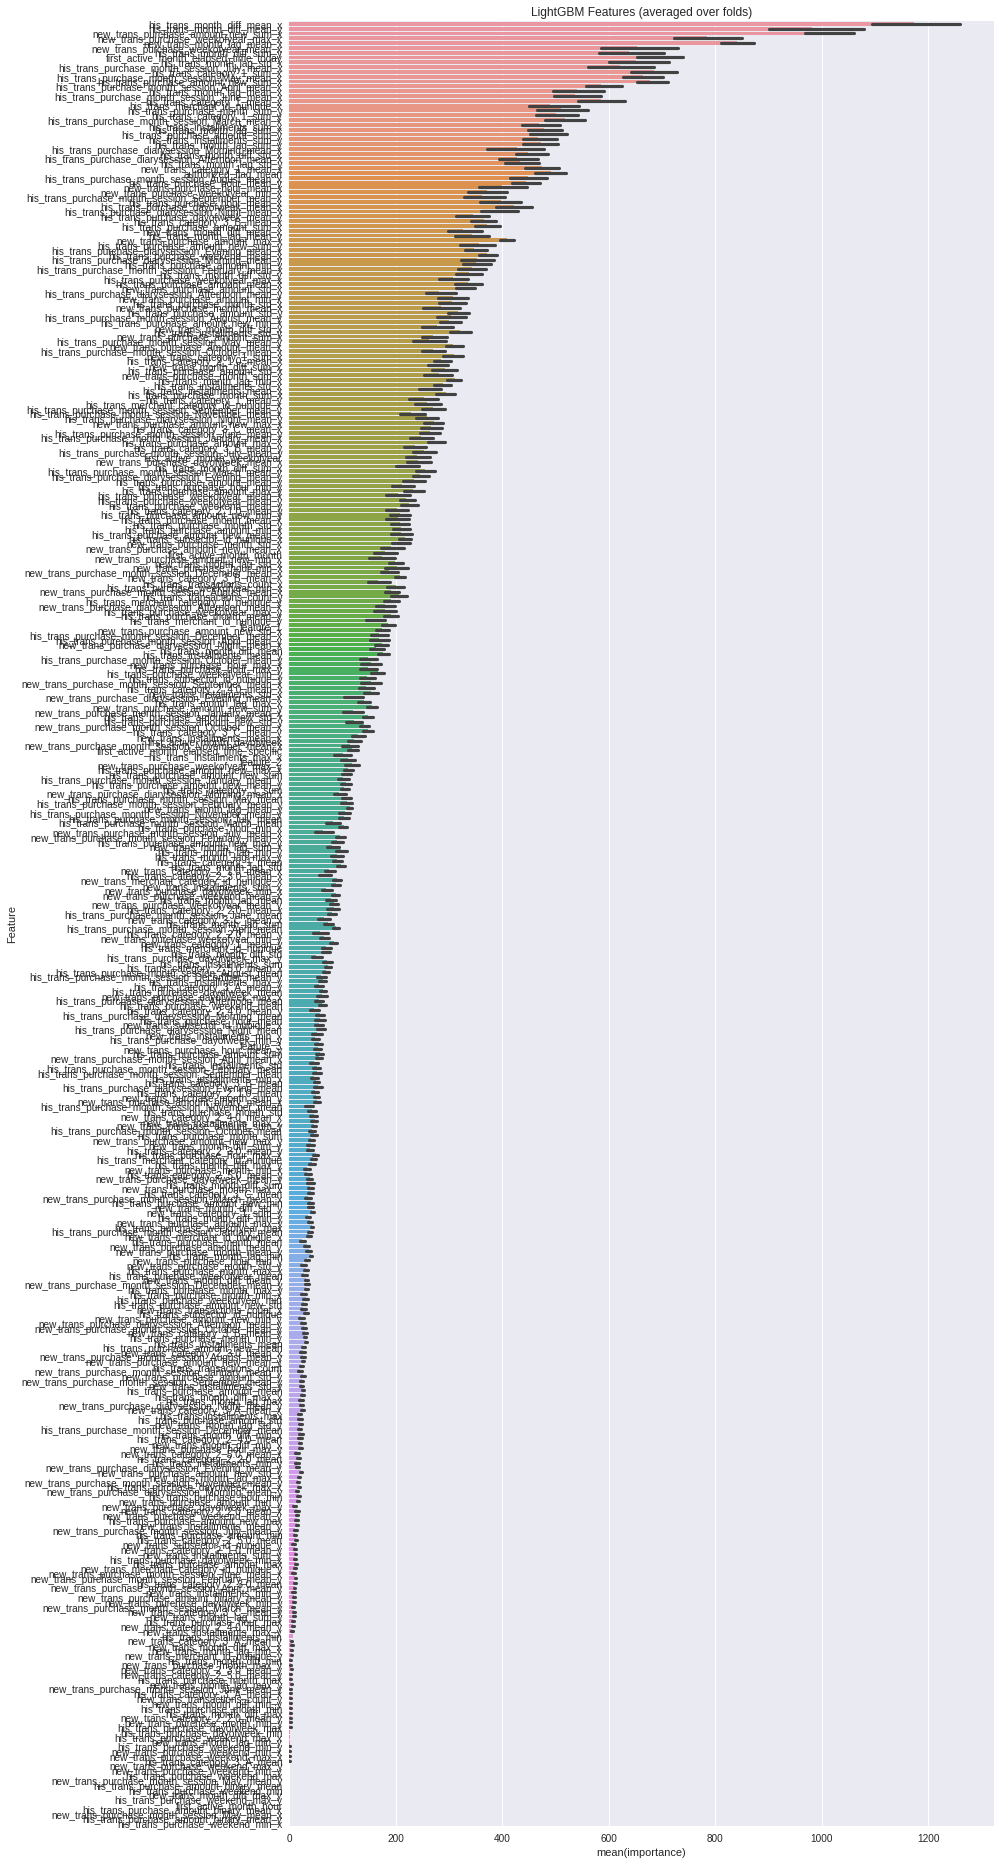

In [0]:
logger.info("Feature importance plot")
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = \
    feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
importances = best_features.sort_values(by="importance",ascending=False)

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=importances)
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()

importances_ = best_features.sort_values(by="fold",ascending=False).sort_values(by="importance",ascending=False)

submit_path = "./model/collector/model_featImportance_20190213.csv"
importances.to_csv(submit_path, index=None)
# plt.savefig('lgbm_importances.png')

In [0]:
best_features.set_index("fold", inplace=True)
best_features.loc[2, :].sort_values(by="importance",ascending=False)

,Feature,importance
fold,,
2,his_trans_month_diff_mean_x,1254
2,his_trans_month_diff_mean_y,1133
2,new_trans_purchase_amount_new_sum_x,1088
2,new_trans_purchase_weekofyear_max_x,841
2,new_trans_month_lag_mean_x,824
2,his_trans_category_1_sum_x,785
2,new_trans_purchase_weekofyear_mean_x,754
2,first_active_month_elapsed_time_today,730
2,his_trans_month_lag_std_x,728


In [0]:
# best_features.set_index("fold", inplace=True)
best_features.loc[5, :].sort_values(by="importance",ascending=False)

,Feature,importance
fold,,
5,his_trans_month_diff_mean_x,1074
5,new_trans_purchase_amount_new_sum_x,960
5,his_trans_month_diff_mean_y,905
5,new_trans_month_lag_mean_x,789
5,new_trans_purchase_weekofyear_max_x,721
5,his_trans_purchase_amount_new_sum_x,659
5,first_active_month_elapsed_time_today,633
5,his_trans_category_1_sum_x,600
5,his_trans_purchase_month_session_May_mean_x,590


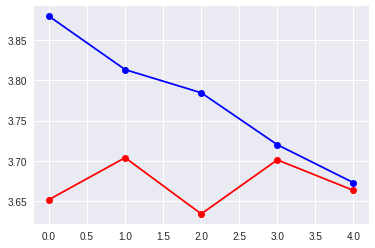

In [0]:
loss_train_df = pd.DataFrame(loss_train)
loss_valid_df = pd.DataFrame(loss_valid)

plt.plot(np.arange(loss_train_df.shape[1]), loss_train_df.loc[0, :].values, "bo-", np.arange(loss_valid_df.shape[1]), loss_valid_df.loc[0, :].values, "ro-");

In [0]:
logger.info("Prepare submission")
submit_sample =  pd.read_csv("./submit/sample_submission.csv")
submit_sample["target"] = predictions
submit_sample.to_csv("./submit/submission_LGBM_hzq_20190214.csv", index=False)

[INFO]2019-02-14 11:27:24,854:main:Prepare submission


## model validation


# Test Parts

In [0]:
import gc, sys
gc.collect()
sys._clear_type_cache()